In [1]:
import os
import gc
import torch
import numpy as np
from utils import plotting
from utils.frozenlake import make_frozenlake
from algorithms.DQN_Agent import DQN_Agent
from algorithms.IDS import IDS_Agent
from algorithms.UCB import UCB_Agent
from algorithms.NEW import NewAlg_Agent
from algorithms.c51 import C51Agent

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Used for debugging; CUDA related errors shown immediately.

# Seed everything for reproducible results
seed = 2024
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

cuda


In [3]:
class Model_TrainTest:
    def __init__(self, seed, device, hyperparams, agent_type='dqn'):
        # Define RL Hyperparameters
        self.train_mode             = hyperparams["train_mode"]
        self.save_interval          = hyperparams["save_interval"]
        
        self.clip_grad_norm         = hyperparams["clip_grad_norm"]
        self.learning_rate          = hyperparams["learning_rate"]
        self.discount_factor        = hyperparams["discount_factor"]
        self.batch_size             = hyperparams["batch_size"]
        self.update_frequency       = hyperparams["update_frequency"]
        self.max_episodes           = hyperparams["max_episodes"]
        self.max_episode_length     = hyperparams["max_episode_length"]
        self.max_steps              = hyperparams["max_steps"]
        self.render                 = hyperparams["render"]
        
        self.epsilon_max            = hyperparams["epsilon_max"]
        self.epsilon_min            = hyperparams["epsilon_min"]
        self.epsilon_decay          = hyperparams["epsilon_decay"]
        
        self.memory_capacity        = hyperparams["memory_capacity"]
        
        self.num_states             = hyperparams["num_states"]
        # self.map_size               = hyperparams["map_size"]
        self.map                    = hyperparams["map"]
        self.render_fps             = hyperparams["render_fps"]
        
        self.env = make_frozenlake(self.map)
        self.env.metadata['render_fps'] = self.render_fps # For max frame rate make it 0
        self.agent_type = agent_type
        # Define the agent class
        self.agent = None
        self.reset_agent()
        self.agent_type = agent_type
        self.state_history = []
        self.loss_bins = []

    def state_preprocess(self, state:int, num_states:int):
        """
        Convert an state to a tensor and basically it encodes the state into
        an onehot vector. For example, the return can be something like tensor([0,0,1,0,0])
        which could mean agent is at state 2 from total of 5 states.

        """
        onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector
    
    
    def reset_agent(self):
        if self.agent_type == 'dqn':
            self.agent = DQN_Agent(env            = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        if self.agent_type == 'ucb':
            self.agent = UCB_Agent(env            = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)
        if self.agent_type == 'ids':
            self.agent = IDS_Agent(   env               = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity,
                                num_ensembles     = 10)
        if self.agent_type == 'new':
            self.agent = NewAlg_Agent(   env               = self.env,
                                seed              = seed,
                                device            = device,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity,
                                num_ensembles     = 10)
        if self.agent_type == 'c51':
            support_size = 51 # n atoms
            v_min = -10
            v_max = 10
            self.agent = C51Agent(env=self.env, 
                                  seed=seed, 
                                  device=device, 
                                  epsilon_max=self.epsilon_max,
                                  epsilon_min=self.epsilon_min, 
                                  epsilon_decay=self.epsilon_decay,
                                  clip_grad_norm=self.clip_grad_norm, 
                                  learning_rate=self.learning_rate,
                                  discount=self.discount_factor,
                                  memory_capacity=self.memory_capacity,
                                  support_size=support_size,
                                  v_min=v_min, 
                                  v_max=v_max)
    
    def run(self, training, agent=None):
        """                
        Reinforcement learning training loop.
        """        
        total_steps = 0
        episode = 0
        self.reward_history = []
        self.episode_length_history = []
        self.environment_steps_history = []
        if not training:
            self.agent = agent
        else:
            self.reset_agent()

        # Training loop over episodes
        while total_steps < self.max_steps:
            state = self.env.reset()
            self.state_history.append(state)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
                                                
            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation = self.env.step(action)
                self.state_history.append(next_state)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)

                if(training):
                    self.agent.replay_memory.store(state, action, next_state, reward, done)

                    # if len(self.agent.replay_memory) > self.batch_size and sum(self.reward_history) > 0: This was the original but since we have a negative reward so the sum doesn't work the same way anymore
                    if len(self.agent.replay_memory) > self.batch_size:
                        self.agent.learn(self.batch_size, (done or truncation))

                        # Update target-network weights
                        if (total_steps+step_size) % self.update_frequency == 0:
                            self.agent.hard_update()

                    if not truncation and step_size >= self.max_episode_length:
                        truncation = True
                
                state = next_state
                episode_reward += reward
                step_size +=1
                            
            # Appends for tracking history
            total_steps += step_size
            self.reward_history.append(episode_reward) # episode reward    
            self.episode_length_history.append(step_size) # episode length
            self.environment_steps_history.append(total_steps) # total steps
            episode += 1
                                                                           
            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()
            
            result = (f"Episode: {episode}, "
                      f"Total Steps: {total_steps}, "
                      f"Raw Reward: {episode_reward:.2f}, ")
            print(result)
        return self.agent                                                
    
    def plot_training(self):
        plotting.plot_binned_line_with_std([self.environment_steps_history], [self.reward_history], self.n_bins, y_label="Reward", title=f"Reward over time ({self.agent_type})", plot_individuals=False)
        plotting.plot_binned_line_with_std([self.environment_steps_history], [self.episode_length_history], self.n_bins, y_label="Episode Length", title=f"Episode Length over time ({self.agent_type})", plot_individuals=False)
        print(len(self.environment_steps_history[3:]), len(self.agent.loss_history))
        plotting.plot_binned_line_with_std([self.environment_steps_history[3:]], [self.agent.loss_history], self.n_bins, y_label="Loss", title=f"Loss over time ({self.agent_type})", plot_individuals=False)

    def get_plotting_data(self):
        padded_loss_history = np.array(self.agent.loss_history)
        while len(padded_loss_history) < len(self.environment_steps_history):
            padded_loss_history = np.concatenate(([padded_loss_history[0]],padded_loss_history))
        return self.environment_steps_history, self.reward_history, self.episode_length_history, padded_loss_history.tolist(), self.state_history

In [4]:
no_aleatoric_uncertainty_3x3 = [
    ['S', '.', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

safe_3x3 = [
    ['S', 'X', '.'],
    ['.', '.', '.'],
    ['.', '.', 'G']
]

long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', 'X', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

short_unsafe_long_safe_4x3 = [
    ['S', 'X', 'G'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', '.']
]

unsafe_path_safe_area_3x4 = [
    ['S', '.', 'X', '.'],
    ['.', '.', '.', '.'],
    ['.', '.', 'X', 'G']
]

random_test_4x4 = [
    ['S', '.', 'X'],
    ['.', '.', '.'],
    ['.', 'X', '.'],
    ['.', '.', 'G']
]

In [8]:
def plot_results(env_steps_histories, eps_length_histories, map_state_histories, agent_reward_histories, agent_loss_histories, state_map, agents, n_bins):
    if train_mode:
        plotting.plot_binned_line_with_std(env_steps_histories, agent_reward_histories, n_bins, y_label="Reward", title="Reward over time", plot_individuals=True)
        plotting.plot_binned_line_with_std(env_steps_histories, eps_length_histories, n_bins, y_label="Episode Length", title="Episode Length over time", plot_individuals=True)
        plotting.plot_binned_line_with_std(env_steps_histories, agent_loss_histories, n_bins, y_label="Loss", title="Loss over time", plot_individuals=True)
    else:
        for i in range(len(map_state_histories)):
            state_table = np.zeros_like(state_map)
            print(agents[i].get_best_actions(state_table, device))
            plotting.plot_grid_statespace(map_state_histories[i], agents[i].get_best_actions(state_table, device), state_map)
        plotting.plot_barchart_rewards(agent_reward_histories, y_label="Reward Counts", title="Bar Chart of Unique Values and Their Corresponding Reward Counts")
        plotting.plot_barchart_episode_length(eps_length_histories, n_bins, y_label='Amount of Finished Runs', title="Bar Chart of Unique Values and Their Corresponding Reward Counts")
        
def run_model(agents):
    DRL = Model_TrainTest(seed, device, RL_hyperparams, agent_type=agent_type) # Define the instance
    environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories = [], [], [], [], []
    if train_mode:
        # 20 runs per agent
        for i in range(5):
            print(i)
            trained_agent = DRL.run(train_mode, None)
            agents.append(trained_agent)
    
            # Save all the data for plotting (plotted in next cell)
            environment_steps_history, reward_history, episode_length_history, loss_history, state_history = DRL.get_plotting_data()
            environment_steps_histories.append(environment_steps_history)
            reward_histories.append(reward_history)
            episode_length_histories.append(episode_length_history)
            loss_histories.append(loss_history)
            state_histories.append(state_history)
    else:
        for agent in agents:
            DRL.run(train_mode, agent)
            
            # Save all the data for plotting (plotted in next cell)
            environment_steps_history, reward_history, episode_length_history, loss_history, state_history = DRL.get_plotting_data()
            environment_steps_histories.append(environment_steps_history)
            reward_histories.append(reward_history)
            episode_length_histories.append(episode_length_history)
            loss_histories.append(loss_history)
            state_histories.append(state_history)
    return environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agents

In [9]:
# Parameters:
train_mode = True
agent_type = 'c51'               # 'dqn', 'ucb', 'ids', 'new', 'c51'

render = not train_mode

state_map = short_unsafe_long_safe_4x3
RL_hyperparams = {
    "train_mode"            : train_mode,

    "save_interval"         : 500,
    
    "clip_grad_norm"        : 3,
    "learning_rate"         : 1e-3,
    "discount_factor"       : 0.99,
    "batch_size"            : 32,
    "update_frequency"      : 200,
    "max_episodes"          : 100000000           if train_mode else 200,
    "max_steps"             : 1000,               
    "max_episode_length"    : 1000,
    "render"                : render,
    
    "epsilon_max"           : 0.999         if train_mode else 0,
    "epsilon_min"           : 0.01,
    "epsilon_decay"         : 0.998,
    
    "memory_capacity"       : 4_000        if train_mode else 0,

    "num_states"            : len(state_map) * len(state_map[0]),   
    "map"                   : state_map,
    "render_fps"            : 6,
    }

n_bins = 50
environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agent_histories = run_model([])

0
Episode: 1, Total Steps: 2, Raw Reward: -5.00, 
Episode: 2, Total Steps: 5, Raw Reward: -5.00, 
Episode: 3, Total Steps: 7, Raw Reward: -5.00, 
Episode: 4, Total Steps: 9, Raw Reward: -5.00, 
Episode: 5, Total Steps: 10, Raw Reward: -5.00, 
Episode: 6, Total Steps: 13, Raw Reward: -5.00, 
Episode: 7, Total Steps: 17, Raw Reward: -5.00, 
Episode: 8, Total Steps: 21, Raw Reward: -5.00, 
Episode: 9, Total Steps: 25, Raw Reward: -5.00, 
Episode: 10, Total Steps: 28, Raw Reward: -5.00, 
Episode: 11, Total Steps: 29, Raw Reward: -5.00, 
Episode: 12, Total Steps: 32, Raw Reward: -5.00, 
Episode: 13, Total Steps: 34, Raw Reward: -5.00, 
Episode: 14, Total Steps: 36, Raw Reward: -5.00, 
Episode: 15, Total Steps: 47, Raw Reward: -5.00, 
Episode: 16, Total Steps: 51, Raw Reward: -5.00, 
Episode: 17, Total Steps: 52, Raw Reward: -5.00, 
Episode: 18, Total Steps: 63, Raw Reward: 10.00, 
Episode: 19, Total Steps: 67, Raw Reward: -5.00, 
Episode: 20, Total Steps: 68, Raw Reward: -5.00, 
Episode: 21

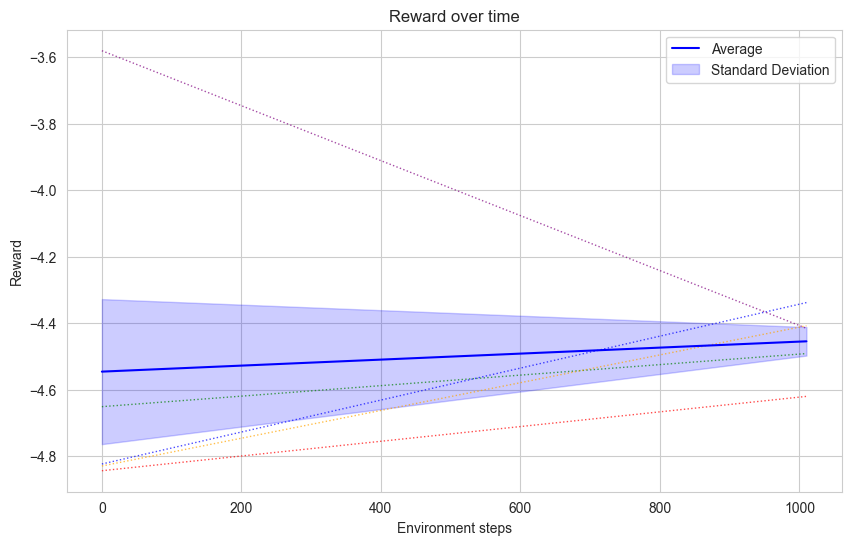

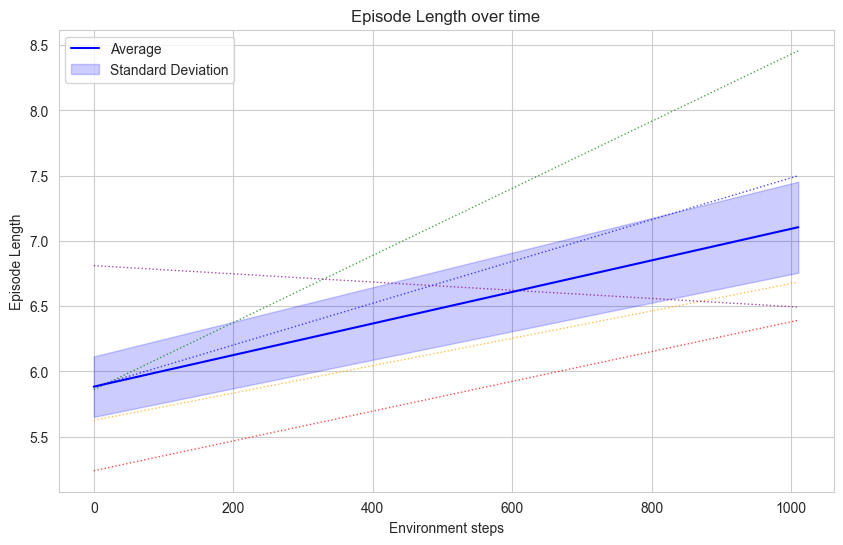

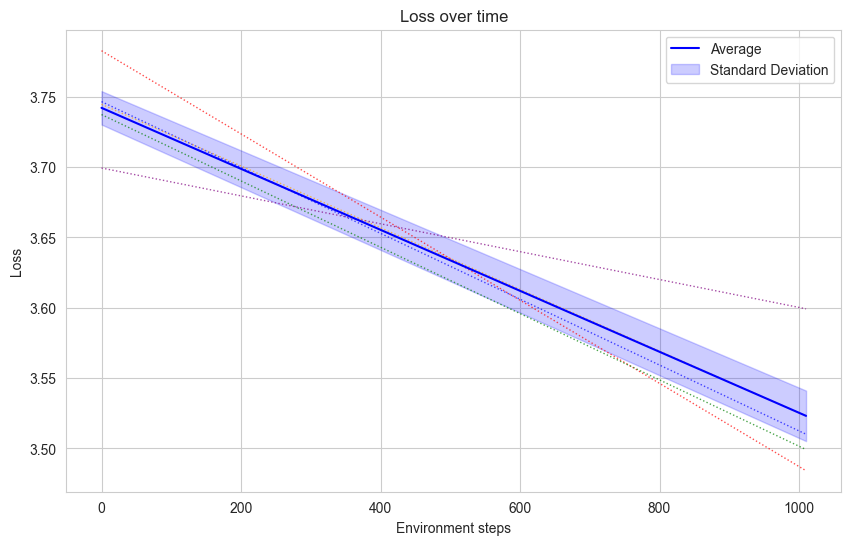

In [10]:
n_bins = 2
plot_results(environment_steps_histories, episode_length_histories, state_histories, reward_histories, loss_histories, state_map, agent_histories, n_bins)

In [11]:
if agent_type != 'c51':
    train_mode = False
    RL_hyperparams[train_mode] = train_mode
    
    environment_steps_histories, reward_histories, episode_length_histories, loss_histories, state_histories, agent_histories = run_model(agent_histories)
    
    plot_results(environment_steps_histories, episode_length_histories, state_histories, reward_histories, loss_histories, state_map, agent_histories, n_bins)

Episode: 1, Total Steps: 3, Raw Reward: -5.00, 
Episode: 2, Total Steps: 20, Raw Reward: -5.00, 
Episode: 3, Total Steps: 34, Raw Reward: -5.00, 
Episode: 4, Total Steps: 45, Raw Reward: -5.00, 
Episode: 5, Total Steps: 57, Raw Reward: -5.00, 
Episode: 6, Total Steps: 59, Raw Reward: -5.00, 
Episode: 7, Total Steps: 67, Raw Reward: -5.00, 
Episode: 8, Total Steps: 76, Raw Reward: -5.00, 
Episode: 9, Total Steps: 81, Raw Reward: -5.00, 
Episode: 10, Total Steps: 84, Raw Reward: -5.00, 
Episode: 11, Total Steps: 85, Raw Reward: -5.00, 
Episode: 12, Total Steps: 87, Raw Reward: -5.00, 
Episode: 13, Total Steps: 105, Raw Reward: -5.00, 
Episode: 14, Total Steps: 115, Raw Reward: -5.00, 
Episode: 15, Total Steps: 116, Raw Reward: -5.00, 
Episode: 16, Total Steps: 121, Raw Reward: -5.00, 
Episode: 17, Total Steps: 137, Raw Reward: -5.00, 
Episode: 18, Total Steps: 138, Raw Reward: -5.00, 
Episode: 19, Total Steps: 145, Raw Reward: -5.00, 
Episode: 20, Total Steps: 150, Raw Reward: -5.00, 
Ep

AttributeError: 'C51Agent' object has no attribute 'get_best_actions'